In [1]:
print("ello")

ello


Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0x22a4cd61
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 200 rows and 200 columns
Presolve time: 0.05s
Presolved: 1250 rows, 5900 columns, 26800 nonzeros
Variable types: 0 continuous, 5900 integer (5900 binary)

Root relaxation: object

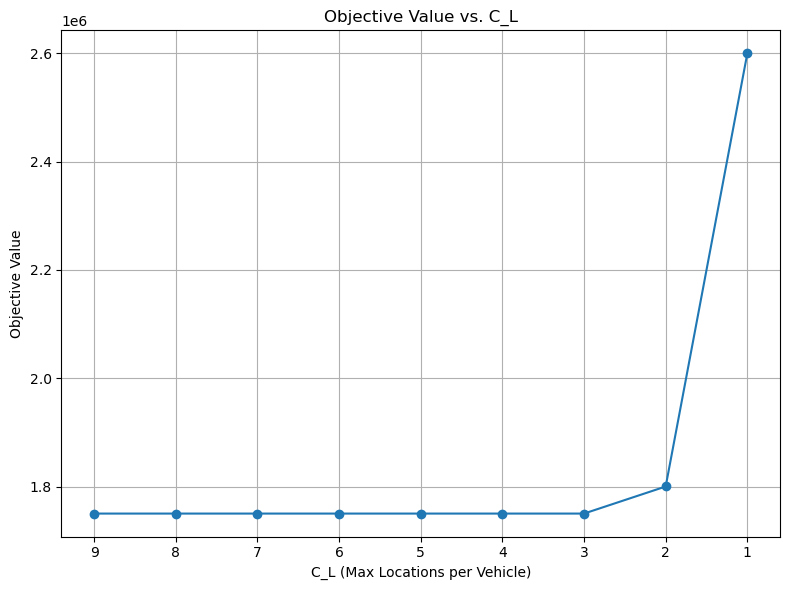

[1750010.925794828, 1750011.0, 1750011.0, 1750011.0, 1750011.0, 1750011.0, 1750011.0, 1800011.0, 2600010.0]


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(10, 30),
     'volume': random.randint(10, 30),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Turn OFF to keep silent
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect objective value
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)

In [4]:
import gurobipy as gp
from gurobipy import GRB
import random
# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
C_L = 7   # Max locations per vehicle
locations = 10
task_count = 20

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(5, 30), 
     'volume': random.randint(5, 30),
     'loc': random.randint(0, locations-1)}
    for _ in range(task_count)
]

# print("Tasks:", tasks)

# Vehicle Fleet Parameters
num_large = 10
num_small = 20

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = []
for i in range(num_large):
    vehicles.append(large_vehicle_spec.copy())
for i in range(num_small):
    vehicles.append(small_vehicle_spec.copy())

# print(f"Fleet: {num_large} large + {num_small} small = {len(vehicles)} total vehicles")

# ======================
# Gurobi Model Formulation (Silent Mode)
# ======================
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 0)      # Suppress all output
    env.setParam('LogToConsole', 0)    # Suppress console logging
    env.start()
    
    # Create Gurobi model
    model = gp.Model('VRP_Gurobi', env=env)
    
    # Decision Variables
    t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
    o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
    d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")
    
    # Objective Function
    vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
    location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
    model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)
    
    # Constraints
    for i in range(len(tasks)):
        model.addConstr(
            gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1,
            name=f"task_assignment_{i}"
        )
    
    for r in range(len(vehicles)):
        model.addConstr(
            gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'],
            name=f"weight_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'],
            name=f"volume_capacity_{r}"
        )
        model.addConstr(
            gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r],
            name=f"location_limit_{r}"
        )
        model.addConstr(
            gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r],
            name=f"vehicle_usage_{r}"
        )
    
    for l in range(locations):
        for r in range(len(vehicles)):
            model.addConstr(
                gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r],
                name=f"location_visit_{l}_{r}"
            )
    
    # Only MIPGap, no time limit
    model.Params.MIPGap = 0.0       # 1% optimality gap
    
    # Solve Model
    model.optimize()
    
    # ======================
    # Solution Extraction and Output
    # ======================
    if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
        print(f"\nOptimal Objective Value: {model.ObjVal}")
        used_vehicles = [r for r in range(len(vehicles)) if o[r].X > 0.5]
        print(f"Vehicles Used: {len(used_vehicles)}")
        solution = {r: {'tasks': [], 'locations': set()} for r in used_vehicles}
        for i in range(len(tasks)):
            for r in used_vehicles:
                if t[i, r].X > 0.5:
                    solution[r]['tasks'].append(i)
                    solution[r]['locations'].add(tasks[i]['loc'])
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            print(f"\nVehicle {r} ({vehicle_type}):")
            print(f"- Tasks: {sorted(solution[r]['tasks'])}")
            print(f"- Locations: {sorted(solution[r]['locations'])}")
            print(f"- Weight Used: {sum(tasks[i]['weight'] for i in solution[r]['tasks'])}/{vehicles[r]['weight_cap']}")
            print(f"- Volume Used: {sum(tasks[i]['volume'] for i in solution[r]['tasks'])}/{vehicles[r]['volume_cap']}")
        # Location constraint check
        print(f"\nLocation Visit Verification (Max allowed: {C_L}):")
        for r in used_vehicles:
            vehicle_type = "large" if r < num_large else "small"
            locations_visited = len(solution[r]['locations'])
            status = "" if locations_visited <= C_L else "VIOLATION"
            print(f"- Vehicle {r} ({vehicle_type}): {locations_visited} locations {status}")
    elif model.Status == GRB.INFEASIBLE:
        print("Model is infeasible!")
        model.computeIIS()
        model.write("infeasible_model.ilp")
    else:
        print(f"Optimization ended with status: {model.Status}")



Optimal Objective Value: 700009.0
Vehicles Used: 2

Vehicle 3 (large):
- Tasks: [0, 2, 3, 5, 8, 13, 14, 15]
- Locations: [1, 4, 5]
- Weight Used: 145/200
- Volume Used: 118/300

Vehicle 9 (large):
- Tasks: [1, 4, 6, 7, 9, 10, 11, 12, 16, 17, 18, 19]
- Locations: [0, 2, 3, 7, 8, 9]
- Weight Used: 195/200
- Volume Used: 159/300

Location Visit Verification (Max allowed: 7):
- Vehicle 3 (large): 3 locations 
- Vehicle 9 (large): 6 locations 


Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0xd2e861a2
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 50 rows and 0 columns
Presolve time: 0.03s
Presolved: 1400 rows, 6100 columns, 24700 nonzeros
Variable types: 0 continuous, 6100 integer (6100 binary)

Root relaxation: objective

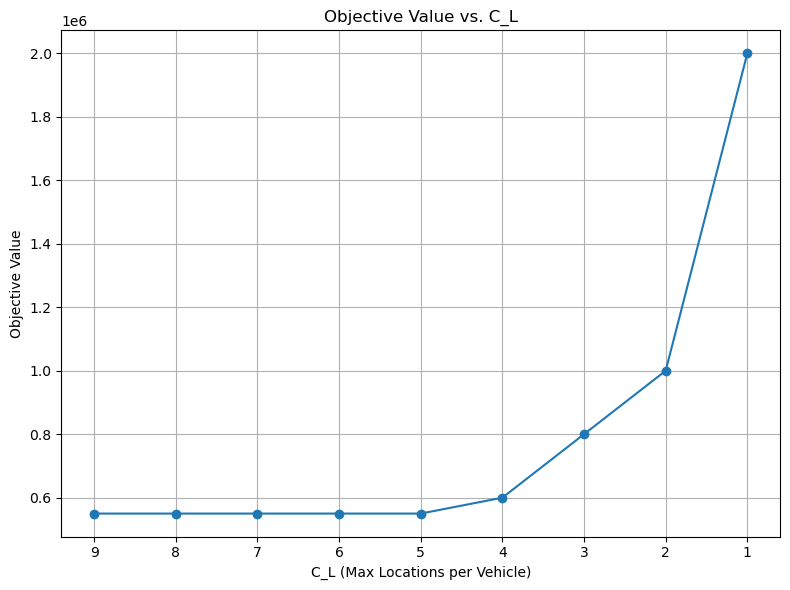

[550010.0, 550010.0, 550010.0, 550010.0, 550010.0, 600010.0, 800010.0, 1000010.0, 2000010.0]


In [5]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(1, 10),
     'volume': random.randint(1, 10),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Turn OFF to keep silent
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect objective value
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)

Set parameter Username
Set parameter LicenseID to value 2616800
Academic license - for non-commercial use only - expires 2026-01-31
Set parameter MIPGap to value 0
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
MIPGap  0

Optimize a model with 1450 rows, 6100 columns and 27200 nonzeros
Model fingerprint: 0x21d22a77
Variable types: 0 continuous, 6100 integer (6100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective 1.185005e+07
Presolve removed 150 rows and 0 columns
Presolve time: 0.04s
Presolved: 1300 rows, 6100 columns, 19700 nonzeros
Variable types: 0 continuous, 6100 integer (6100 binary)

Root relaxation: objectiv

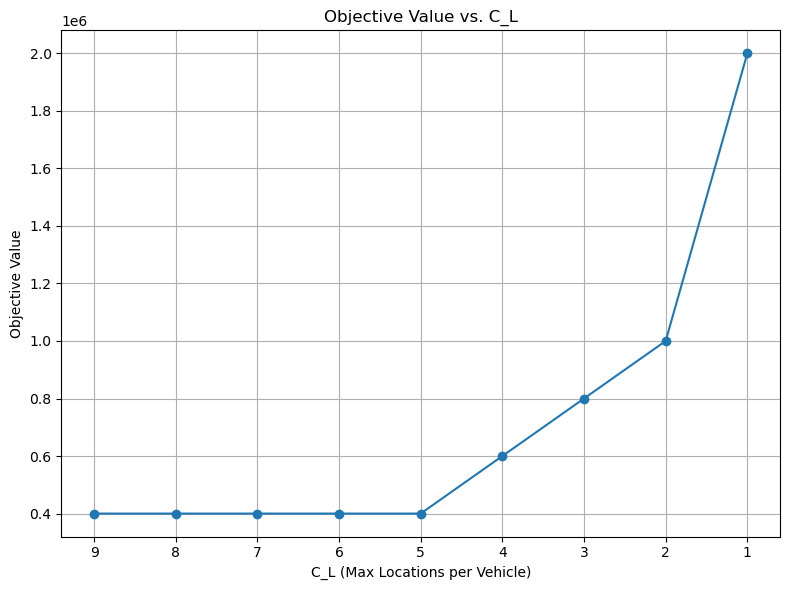

[400010.0, 400010.0, 400010.0, 400010.0, 400010.0, 600010.0, 800010.0, 1000010.0, 2000010.0]


In [6]:
import gurobipy as gp
from gurobipy import GRB
import random
import matplotlib.pyplot as plt

# Problem Instance
random.seed(1234)
M = 1000  # Priority weighting for vehicle costs
locations = 10
task_count = 50

# Generate tasks with random demands and locations
tasks = [
    {'weight': random.randint(1, 5),
     'volume': random.randint(1, 5),
     'loc': random.randint(0, locations - 1)}
    for _ in range(task_count)
]

# Vehicle Fleet Parameters
num_large = 50
num_small = 50

# Vehicle specifications
large_vehicle_spec = {'type': 'large', 'weight_cap': 200, 'volume_cap': 300, 'cost': 350}
small_vehicle_spec = {'type': 'small', 'weight_cap': 100, 'volume_cap': 150, 'cost': 200}

# Generate vehicle fleet
vehicles = [large_vehicle_spec.copy() for _ in range(num_large)] + \
           [small_vehicle_spec.copy() for _ in range(num_small)]

# Results storage
cl_values = list(range(9, 0, -1))
objective_values = []

# Gurobi Silent Environment
with gp.Env(empty=True) as env:
    env.setParam('OutputFlag', 1)      # Turn OFF to keep silent
    env.start()

    for C_L in cl_values:
        model = gp.Model('VRP_Gurobi', env=env)

        # Decision Variables
        t = model.addVars(len(tasks), len(vehicles), vtype=GRB.BINARY, name="task_assign")
        o = model.addVars(len(vehicles), vtype=GRB.BINARY, name="vehicle_used")
        d = model.addVars(locations, len(vehicles), vtype=GRB.BINARY, name="location_visit")

        # Objective Function
        vehicle_cost = gp.quicksum(M * vehicles[r]['cost'] * o[r] for r in range(len(vehicles)))
        location_cost = gp.quicksum(d[l, r] for l in range(locations) for r in range(len(vehicles)))
        model.setObjective(vehicle_cost + location_cost, GRB.MINIMIZE)

        # Constraints
        for i in range(len(tasks)):
            model.addConstr(gp.quicksum(t[i, r] for r in range(len(vehicles))) == 1)

        for r in range(len(vehicles)):
            model.addConstr(gp.quicksum(tasks[i]['weight'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['weight_cap'])
            model.addConstr(gp.quicksum(tasks[i]['volume'] * t[i, r] for i in range(len(tasks))) <= vehicles[r]['volume_cap'])
            model.addConstr(gp.quicksum(d[l, r] for l in range(locations)) <= C_L * o[r])
            model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks))) <= len(tasks) * o[r])

        for l in range(locations):
            for r in range(len(vehicles)):
                model.addConstr(gp.quicksum(t[i, r] for i in range(len(tasks)) if tasks[i]['loc'] == l) <= len(tasks) * d[l, r])

        # Solve for 100% optimality
        model.Params.MIPGap = 0.0

        # Solve
        model.optimize()

        # Collect objective value
        if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
            objective_values.append(model.ObjVal)
        else:
            objective_values.append(None)  # Use None for infeasible or other status

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(cl_values, objective_values, marker='o')
plt.xlabel("C_L (Max Locations per Vehicle)")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. C_L")
plt.grid(True)
plt.gca().invert_xaxis()  # Optional: Show decreasing C_L left to right
plt.tight_layout()
plt.show()
print(objective_values)